In [18]:
import numpy
import typing

def blockproc_reshape(
    array: numpy.ndarray,
    block_size: numpy.ndarray
) -> numpy.ndarray:

    nb_rows, nb_cols = array.shape
    res = None

    step_r, step_c = block_size

    for i in range(0, nb_rows, step_r):

        column = None
        
        for j in range(0, nb_cols, step_c):
            bloc = numpy.reshape(
                array[i:i+step_r, j:j+step_c], 
                (step_r*step_c, 1),
                order='F'
            )
            if column is None:
                column = numpy.copy(bloc)
            else:
                column = numpy.vstack([ column, bloc ])

        if res is None:
            res = numpy.copy(column)
        else:
            res = numpy.hstack([ res, column ])

    return res

def blockproc(
    array: numpy.ndarray, 
    block_shape: numpy.ndarray,
    fun: typing.Callable[[numpy.ndarray], numpy.ndarray]
) -> numpy.ndarray:
    
    nb_rows, nb_cols = array.shape
    step_r, step_c = block_shape
    
    for i in range(0, nb_rows, step_r):
        for j in range(0, nb_cols, step_c):
            array[i:i+step_r, j:j+step_c] = \
                fun(array[i:i+step_r, j:j+step_c])
    
    return array
                
def block_mm(nr, nc, Nb, x1) -> numpy.ndarray:

    block_shape = numpy.array([nr, nc])

    x1 = blockproc_reshape(x1, block_shape)
    #print(x1)
    x1 = numpy.reshape(x1, newshape=(nr*nc, Nb), order='F')
    #print(x1.shape)
    
    x1 = numpy.sum(x1, axis=1)
    #print(x1.shape)
    x = numpy.reshape(x1, newshape=(nr, nc), order='F')

    return x

def decimation(image: numpy.ndarray, d_row: int, d_col: int) -> numpy.ndarray:
    if d_row <= 0:
        raise AssertionError('d_row <= 0')
    if d_col <= 0:
        raise AssertionError('d_col <= 0')
    return numpy.copy(image[0::d_row, 0::d_col])

In [19]:
import sys
sys.path.append('../..')

import numpy
import typing
import pathlib
import PIL.Image

import scipy.signal
import scipy.io.matlab

import lasp.io
import lasp.filters.linear
import lasp.utils

In [20]:
datas = {}
# PARAMETERS

d = 4
nr, nc = 512//4, 512//4
m = nr*nc
nrup, ncup = d*nr, d*nc
Nb = d*d
mu = 0.5
gam = 0.5
maxiter = 100

# IMG

refl = lasp.io.read(pathlib.Path('lena.bmp'))

# BLUR

# B = lasp.filters.linear.gaussian_filter(3, 3)
B = numpy.ones(shape=(7, 3))
FB = lasp.utils.fourier_diagonalization(B, shape_out=numpy.array(refl.shape))
FBC = numpy.conj(FB)
F2B = numpy.abs(FB) ** 2

# DECIMATION
y = scipy.signal.convolve2d(refl, B, mode='same')
yinp = numpy.array(
    PIL.Image.Image.resize(
        PIL.Image.fromarray(y), 
        (refl.shape[1], refl.shape[0]), 
        PIL.Image.Resampling.BICUBIC
    ),
    dtype=numpy.double
)
y = decimation(y, d, d)
STy = numpy.zeros(shape=(nrup, ncup))
STy[0::d, 0::d] = y
FBTSTy = FBC * numpy.fft.fft2(STy)

datas['d'] = d
datas['nr'] = nr
datas['nc'] = nc
datas['mu'] = mu
datas['gam'] = gam
datas['refl'] = numpy.copy(refl)
datas['B'] = numpy.copy(B)
datas['y'] = numpy.copy(y)
datas['yinp'] = numpy.copy(yinp)
datas['maxiter'] = maxiter
scipy.io.matlab.savemat('datas.mat', datas)



# DISCRETE OPERATOR

dh = numpy.zeros(shape=(nrup, ncup))
dh[0, 0] = 1
dh[0, 1] = -1

dv = numpy.zeros(shape=(nrup, ncup))
dv[0, 0] = 1
dv[1, 0] = -1

FDH = numpy.fft.fft2(dh)
FDHC = numpy.conj(FDH)
F2DH = numpy.abs(FDH)**2

FDV = numpy.fft.fft2(dv)
FDVC = numpy.conj(FDV)
F2DV = numpy.abs(FDV)**2

c = 1e-8
F2D = F2DH + F2DV + c

In [21]:
X = numpy.copy(yinp)
FX = numpy.fft.fft2(X)
BX = numpy.real(numpy.fft.ifft2(FB*FX))
U1 = numpy.copy(X)
U2 = numpy.copy(X)
D1 = numpy.zeros_like(X)
D2 = numpy.zeros_like(X)

for i in range(0, maxiter):
    #print('#######################################################')
    #print('Iteration {}:\n'.format(i))
    
    # Update X
    V1 = U1-D1
    V2 = U2-D2
    FV1 = mu*FDHC*numpy.fft.fft2(V1)
    FV2 = mu*FDVC*numpy.fft.fft2(V2)
    FR = FBTSTy + FV1 + FV2
    #print('FR :', FR)

    ## INVLS
    x1 = FB*FR / F2D
    FBR = block_mm(nr, nc, Nb, x1)
    invW = block_mm(nr, nc, Nb, F2B / F2D)
    invWBR = FBR / (invW + mu * Nb)
    fun = lambda block : block*invWBR
    FCBinvWBR = blockproc(numpy.copy(FBC), numpy.array([nr, nc]), fun)
    ### Return
    FX = (FR-FCBinvWBR) / F2D / mu
    X = numpy.real(numpy.fft.ifft2(FX))
    ########
    #print('FX :', FX)
    #print('X :', X)

    # Update U
    DhX = numpy.real(numpy.fft.ifft2(FX*FDH))
    #print('DhX :', DhX)
    DvX = numpy.real(numpy.fft.ifft2(FX*FDV))
    #print('DvX :', DvX)
    NU1 = DhX + D1
    #print('NU1 :', NU1)
    NU2 = DvX + D2
    #print('NU2 :', NU2)
    NU = numpy.sqrt(NU1**2 + NU2**2)
    #print('NU :', NU)
    A = numpy.where(0 < NU-gam, NU-gam, 0)
    #print('A :', A)
    A = A / (A + gam)
    #print('A :', A)
    U1 = A*NU1
    #print('U1 :', U1)
    U2 = A*NU2
    #print('U2 :', U2)

    # Update D
    D1 = D1 + (DhX - U1)
    #print('D1 :', D1)
    D2 = D2 + (DvX - U2)
    #print('D2 :', D2)

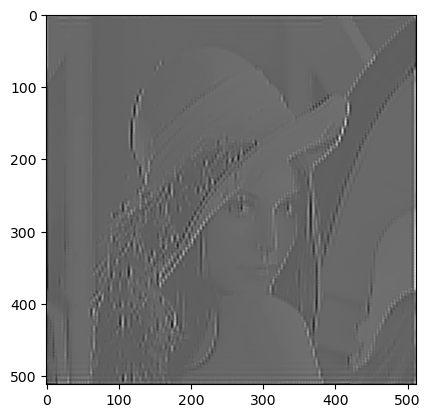

In [23]:
import matplotlib.pyplot
matplotlib.pyplot.imshow(X, cmap='gray')